# **DataDriven.Nola.gov Data Analysis**

In [ ]:
# Install necessary libraries
!pip install bertopic
!pip install geopandas
import pandas as pd
import geopandas as gpd
import spacy
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import Point, Polygon
from shapely import wkt

### **Public Records Requests**
Using BERTopic, we performed topic modeling on the public records requests data to gauge community data interests and determine the most frequently requested data topics. By manipulating the parameters, we trained four different models, and the topics showing up in the results of all four models were deemed the most important/relevant data topics.

In [ ]:
#requests data - convert to list of strings
requests = pd.read_csv('Public_Records_Requests.csv')
display(requests['Request Text'].head())
requests = requests['Request Text'].tolist()

0    Any and all contracts between the city of New ...
1    Hello, hoping to get any records of hazardous ...
2    Please send me a copy of all pre and post tax ...
3    Please provide the following information about...
4    I am requesting public records of the city's e...
Name: Request Text, dtype: object

Below, we train our first model. We end up with the most frequently appearing topics in the data, each represented by a set of words. The 20 most frequent topics are displayed in the chart below.

In [ ]:
# training
topic_model_1 = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model_1.fit_transform(requests)

Batches:   0%|          | 0/242 [00:00<?, ?it/s]

In [ ]:
# save model 1
topic_model_1.save("PublicRecords_Model1")	

In [ ]:
# most frequent topics: -1 indicates outliers, ignore
freq = topic_model_1.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,-1,2530,-1_the_and_of_in
1,0,223,0_fire_report_occurred_incident
2,1,144,1_camera_footage_video_accident
3,2,135,2_fire_incident_report_occurred
4,3,132,3_rfp_proposals_selection_evaluation
5,4,104,4_public_records_fees_act
6,5,104,5_paid_taxes_nola_st
7,6,100,6_street_permits_orleans_new
8,7,93,7_incident_initial_report_view
9,8,93,8_paid_taxes_years_la


The most frequent topic in the public records requests apprears to be fire incident reports in New Orleans. Below is the cluster of words representing this topic.

In [ ]:
topic_model_1.get_topic(0) # get the most frequent topic

[('fire', 0.05267922523855218),
 ('report', 0.03489122195061917),
 ('occurred', 0.03273741016577411),
 ('incident', 0.025259593276499192),
 ('la', 0.02479762762000258),
 ('involving', 0.02093564846224196),
 ('new', 0.018817773365469956),
 ('orleans', 0.01856295081160376),
 ('on', 0.017813844971275566),
 ('at', 0.01724144049364158)]

The second most frequent topic is related to traffic camera footage.

In [ ]:
topic_model_1.get_topic(1) # get the 2nd most frequent topic

[('camera', 0.03233983545989223),
 ('footage', 0.03190395171780871),
 ('video', 0.03158366868124489),
 ('accident', 0.03074310280447741),
 ('intersection', 0.030413903174532117),
 ('pm', 0.02656250932480622),
 ('traffic', 0.017989825800340278),
 ('cameras', 0.015957888315200414),
 ('at', 0.015665788564913737),
 ('on', 0.015453408727017172)]

Based on the relationship between the words representing each topic, we label each topic and display the 10 most frequent topics below.

In [ ]:
# Set labels for top 10 topics
topic_model_1.set_topic_labels({0: "Fire Incident", 1: "Traffic Camera Footage",
                                2: "Fire Incident", 3: "RFP", 4: "Public Records Requests",
                                5: "Tax Payment", 6: "Street Permits", 7: "Incident Reports",
                                8: "Taxes", 9: "Emails"})

# Display model 1 bar chart
topic_model_1.visualize_barchart(top_n_topics=10, title='Model 1: Topic Word Scores',
                                 custom_labels=True)

Now, we update the topics from model 1 by modifying the parameters. By changing the N-gram range, we can control how many words are included in each entity of a topic. This is set to its default value of 1 in our original model, meaning that each topic is represented by a group of singular words. We now change this to a range of (1, 3), so each entity in a topic can be up to 3 words. For example, "New" and "Orleans" are two separate words, but can now be considered as a single term "New Orleans" in our topic representation. Let's see how this affects our results.

In [ ]:
# change ngram_range, let each entity in a topic be up to 3 words
vectorizer_model = CountVectorizer(ngram_range=(1, 3))

# update model 1
topic_model_1.update_topics(requests, vectorizer_model=vectorizer_model)

In [ ]:
# get most frequent topics: ngram_range = (1,3)
freq = topic_model_1.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,-1,2374,-1_the_and_of_to
1,0,364,0_paid_tax_bill_taxes
2,1,223,1_fire_report_the fire_fire report
3,2,143,2_rfp_proposals_rfp no_proposal
4,3,134,3_fire_report_incident_fire report
5,4,132,4_camera_footage_accident_intersection
6,5,110,5_public_records_request_public records
7,6,96,6_bid_group_tabulations_bid tabulations
8,7,89,7_contract_the city_the city of_city
9,8,87,8_incident_initial incident_incident report_in...


After changing the N-gram range, our most frequent topics have changed slightly, but there are still similarities to our original model. Some notable topics include **fire incident reports, body camera footage, and 911 calls.**

We will now manipulate the BERTopic parameters to create a new model. By changing the minimum topic size to 5 (from its default value of 10), topics can be comprised of less words. Lowering this value means that more topics are created. Shown below is a chart of the 20 most frequent topics using model 2.

In [ ]:
# train a new model with modified topic sizes (min topic size = 5)
topic_model_2 = BERTopic(language="english", min_topic_size=5, calculate_probabilities=True, verbose=True)
topics, probs = topic_model_2.fit_transform(requests)

Batches:   0%|          | 0/242 [00:00<?, ?it/s]

In [ ]:
# save model 2
topic_model_2.save("PublicRecords_Model2")	

In [ ]:
# most frequent topics: model 2
freq = topic_model_2.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,-1,2122,-1_the_and_in_of
1,0,365,0_paid_bill_taxes_tax
2,1,243,1_fire_report_occurred_incident
3,2,132,2_video_footage_intersection_accident
4,3,79,3_rfp_proposals_sheets_scoring
5,4,77,4_incident_initial_view_report
6,5,74,5_permit_permits_seasons_issued
7,6,74,6_code_violations_open_parcel
8,7,69,7_bid_unit_prices_tabulations
9,8,68,8_body_footage_camera_cam


The two most frequent topics are related to tax payments and fire incidents. The word groups representing these topics are displayed below.

In [ ]:
topic_model_2.get_topic(0) # get the most frequent topic

[('paid', 0.030763668590070976),
 ('bill', 0.022534097061466675),
 ('taxes', 0.021453433857983782),
 ('tax', 0.01726269520375312),
 ('bills', 0.014618764186750375),
 ('payment', 0.013607243854968174),
 ('years', 0.013133040618896929),
 ('need', 0.011279474878138566),
 ('amount', 0.01105217765898051),
 ('property', 0.01071072975638051)]

In [ ]:
topic_model_2.get_topic(1) # get the 2nd most frequent topic

[('fire', 0.03495184621558374),
 ('report', 0.023251193681501966),
 ('occurred', 0.022447373691165347),
 ('incident', 0.018760099343314),
 ('la', 0.015005217922794222),
 ('involving', 0.014626335187983272),
 ('new', 0.010739276696985394),
 ('on', 0.010698407010312922),
 ('orleans', 0.010648460715898724),
 ('at', 0.010626758741238479)]

In [ ]:
# Set labels for top 10 topics
topic_model_2.set_topic_labels({0: "Tax Payments", 1: "Fire Incident",
                                2: "Traffic Camera Footage", 3: "RFP", 4: "Incident Reports",
                                5: "Permit Applications", 6: "Code Violations", 7: "Pricing",
                                8: "Body Camera Footage", 9: "Fire Incident"})

# Display model 2 bar chart
topic_model_2.visualize_barchart(top_n_topics=10, title='Model 2: Topic Word Scores',
                                 custom_labels=True)

Now, we will train a new model with a topic size of 5. Previously, the size of each topic was greater than or equal to 5; we now restrict all topic sizes to 5 by changing the top_n_words parameter. The more words that are included in a topic, the less coherent that topic can become. This should create more focused topics; let's see how it affects our results. Below are the most frequent topics produced by this model.

In [ ]:
# train a new model with modified topic sizes (topic size = 5)
topic_model_3 = BERTopic(language="english", top_n_words=5, min_topic_size=5,
                         calculate_probabilities=True, verbose=True)
topics, probs = topic_model_3.fit_transform(requests)

Batches:   0%|          | 0/242 [00:00<?, ?it/s]

In [ ]:
# save model 3
topic_model_3.save("PublicRecords_Model3")	

In [ ]:
# most frequent topics: model 3
freq = topic_model_3.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,-1,2424,-1_the_and_in_all
1,0,92,0_paid_taxes_years_bill
2,1,86,1_contract_contracts_services_city
3,2,83,2_permit_permits_applications_issued
4,3,81,3_body_footage_camera_cam
5,4,78,4_accident_video_intersection_camera
6,5,78,5_street_4412a_dating_permits
7,6,76,6_incident_initial_view_report
8,7,76,7_emails_january_2018_received
9,8,75,8_public_fees_act_me


In [ ]:
topic_model_3.get_topic(0) # get the most frequent topic

[('paid', 0.023392599683124887),
 ('taxes', 0.018728375030529702),
 ('years', 0.018574413885267912),
 ('bill', 0.015169417880669438),
 ('la', 0.014078575994031483)]

In [ ]:
topic_model_3.get_topic(1) # get the 2nd most frequent topic

[('contract', 0.02239770790045691),
 ('contracts', 0.018548210489361925),
 ('services', 0.017404181860354244),
 ('city', 0.013677655011864817),
 ('agreements', 0.013673633835138364)]

In [ ]:
# Set labels for top 10 topics
topic_model_3.set_topic_labels({0: "Tax Payment", 1: "Contracts",
                                2: "Permit Applications", 3: "Body Camera Footage", 4: "Traffic Camera Footage",
                                5: "Permits", 6: "Incident Reports", 7: "Emails",
                                8: "Public Records", 9: "Tax Bills"})

# Display model 3 bar chart
topic_model_3.visualize_barchart(top_n_topics=10, title='Model 3: Topic Word Scores',
                                 custom_labels=True)

Some recurring themes: **Taxes, Body Camera Footage, Traffic Camera Footage.**

We will now train a 4th model by manipulating the diversity parameter, which controls the similarity of words included in each topic to reduce redundancies. The diversity value ranges from 0 to 1, with 0 being not at all diverse and 1 being very diverse. The default value is 0; by changing this to 0.5 we will diversify the resulting topic representations. 

In [ ]:
# train new model, add diversity
topic_model_4 = BERTopic(language="english", calculate_probabilities=True, diversity=0.5, verbose=True)
topics, probs = topic_model_4.fit_transform(requests)

Batches:   0%|          | 0/242 [00:00<?, ?it/s]

In [ ]:
# save model 4
topic_model_4.save("PublicRecords_Model4")

In [ ]:
# most frequent topics: model 4
freq = topic_model_4.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,-1,2320,-1_all_records_or_new
1,0,350,0_taxes_bills_st_nola
2,1,223,1_fire_orleans_happened_st
3,2,150,2_accident_intersection_traffic_crime
4,3,136,3_rfp_proposals_evaluation_submitted
5,4,135,4_public_records_fees_louisiana
6,5,123,5_hearing_rental_nicholls_recordings
7,6,115,6_fire_incident_2431_2020
8,7,110,7_group_tabulations_de_proposal
9,8,100,8_contracts_donation_deepwater_oil


The two most frequent topics are again related to taxes and fire incidents.

In [ ]:
topic_model_4.get_topic(0) # get the most frequent topic

[('taxes', 0.02530271397460279),
 ('bills', 0.015073727022006201),
 ('st', 0.010985627874413149),
 ('nola', 0.010229897459317771),
 ('andor', 0.010098585806939566),
 ('estate', 0.008436083284670768),
 ('mail', 0.008332047192687285),
 ('presale', 0.008297518451924642),
 ('payments', 0.008249751830665961),
 ('notices', 0.008010579230723259)]

In [ ]:
topic_model_4.get_topic(1) # get the 2nd most frequent topic

[('fire', 0.05161375796259105),
 ('orleans', 0.01807454606534836),
 ('happened', 0.010803363303864126),
 ('st', 0.01030270774100855),
 ('need', 0.008678603942663536),
 ('avenue', 0.00765552346236769),
 ('department', 0.007624992426648681),
 ('investigation', 0.007187351008425922),
 ('june', 0.006314481830658009),
 ('70119', 0.006110321162769096)]

In [ ]:
# Set labels for top 10 topics
topic_model_4.set_topic_labels({0: "Tax Bills", 1: "Fire Incident",
                                2: "Crime, Traffic Cameras", 3: "RFP", 4: "Public Records",
                                5: "City Court", 6: "Fire Incident", 7: "Proposals",
                                8: "Donations", 9: "Incident Reports"})

# Display model 4 bar chart
topic_model_4.visualize_barchart(top_n_topics=10, title='Model 4: Topic Word Scores',
                                 custom_labels=True)

Now that we've determined several frequent topics based on the results of our 4 models, let's look back at the public records requests and see what people were actually asking for when these topics were mentioned. Shown below are a few requests relating to each of the following topics: traffic cameras, fire incidents, taxes, and body camera footage. Many of these requests are irrelevant or difficult to understand, but there are many that provide some good insight!

In [ ]:
traffic = [x for x in requests if 'traffic' in x and 'camera' in x]
for i in traffic[:5]: print(i, '\n')

On October 11, 2016 my bank account was charged $331. It was paid to "PAM New Orleans". I was told at first it had to do with a parking violation; later, that was changed to be a traffic camera "violation". I would like access to the file that describes who received the $331 and what it was for. Specifically and particularly I need to determine whether that $331 fully paid alleged violations on 6-23-16 and 9-6-16 

I'm requesting the amount of money that’s been generated by the traffic cameras for the New Orleans Police department and other city-run departments for the past four years. Also, I'm requesting the number of tickets issued for the past four using the traffic camera and the amount of tickets that are still outstanding.  
 Thank you, 

To Whom it May Concern: 
 We are a local community small business specializing in digital solutions for New Orleanians. As part of the growing Tech industry, we are always in need of high quality data. In particular, our project needs data for 

In [ ]:
fire = [x for x in requests if 'fire' in x and 'incident' in x]
for i in fire[:3]: print(i, '\n')

Subject:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Freedom of Information Act (FOIA) Request/File Review Request  
 Royal St. Charles Hotel 
 135 St. Charles Avenue, New Orleans, LA 
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Parcel ID#: 036 
 AEI Project No. 373982 
 &nbsp; 
 To whom it may concern: 
 &nbsp; 
 Please accept this as request for any information/documentation/files with your department regarding the above-referenced property. 
 &nbsp; 
 AEI Consultants is currently conducting the Phase I Environmental Site Assessment for the property. The ASTM Practice E1527-13 Standard Practice of Environmental Site Assessments requires that a records search be conducted with local regulatory departments for information regarding the subject property. Of particular interest are the following items: 
 &nbsp; 
 
 Records regarding hazardous materials usage/storage/incidents or know

In [ ]:
taxes = [x for x in requests if 'tax' in x and 'bill' in x]
for i in taxes[:3]: print(i, '\n')

Please send me a copy of all pre and post tax sale notices issued in connection with the 2012 tax sale of 4222-4224 Willow Street and any attempts to notify the&nbsp;property owners of&nbsp;the related&nbsp;2011 tax delinquency. Tax bill number is 614336108. 

Please provide the following: 
 
 Copies of any and all pre and post-tax sale notice provided to any person or entity whatsoever regarding the 2007 tax sale of the property at the municipal address 2724 Fourth (4th) Street, Tax Bill No. 412305008 to Sabrina S. Hankton for unpaid 2005 ad valorem taxes as well as any documentation regarding confirmation of receipt of said pre and post-tax sale notices by any person or entity whatsoever regarding the 2007 tax sale of the property at the municipal address 2724 Fourth (4th) Street, Tax Bill No. 412305008 to Sabrina S. Hankton for unpaid 2005 ad valorem taxes. 
 
 
 Copies of any and all documents regarding any and all requests for redemption/payoff of the 2007 tax sale of the property

In [ ]:
body_cam = [x for x in requests if 'body' in x and 'camera' in x]
for i in body_cam[:5]: print(i, '\n')

We are filing a public records request for the following information: The responding NOPD officer's body camera video (BWC) from item number: I-16415-16. The incident happened 9/15/2016.&nbsp;&nbsp; 

My taxi was broken by somebody during my mechanic was putting some break pads on it. So my bank cards were stolen including my driver license. So I request a camera review toward my car in order to catch the person. I have the police report done and my bank had notified some transactions made! 

The Associated Press makes the follow request for information and public records request concerning body worn cameras: 
 **The number of New Orleanspolice officers issued body worn cameras as of July 1, 2016 
 **Total number of New Orleans&nbsp;police officers as of July 1, 2016 
 **A copy of policies or general police orders governing use of police body worn cameras. 
 **Copies of any audits, studies or reports written between Jan. 1, 2015 and July 1, 2016 for compliance rates for officer use of 

While sifting through some of the public records requests, we came across some interesting information/requests relating to traffic cameras. The following requests were made:

"I am requesting the demographic breakdowns – race, age, sex -- of all people issued traffic tickets by NOPD officers in 2016, 2017, 2018 and 2019. 
I would also like the total number of tickets issued and the total dollar amount of those tickets." 

"I am requesting the demographic breakdowns – race, age, sex -- of all people issued traffic tickets by automated traffic cameras in 2016, 2017, 2018 and 2019. 
I would also like the total number of tickets issued and the total dollar amount of those tickets." 

"Our project needs data for the GPS coordinates for Orleans Parish traffic cameras (speeding and red light). Our team has already assembled a list of locations (according to intersections and major landmarks).  Please accept our information request and make the GPS coordinates of traffic cameras available. This will enable us to reference your authoritative and high quality data as our continuing source of information for our Tech projects."

These are some interesting data requests that could possibly be displayed in a dashboard!

### **Search Feedback**

Below, we import the Search Feedback dataset, which includes the date, search term used, and desired search term. From this data, we can see why users are searching the site, and what they hoped to find.

In [ ]:
search = pd.read_excel('Search Feedback.xlsx',skiprows=2)

In [ ]:
search.head()

,Submitted,Search Term Used,Desired Result,Email
0,2022-10-16 21:13:10,Court times,Court times,Darnellwalker1201@gmail.com
1,2022-10-16 17:55:03,Calucem and Cementos Mullins,The address for the new calucem plant in New O...,vmportermspr@yahoo.com
2,2022-10-16 14:05:19,Sewerage & Water Board,how to report water leaking into street,luckybean@juno.com
3,2022-10-15 19:03:57,Fireworks,Fireworks display dates in New Orleans,randycadle@gmail.com
4,2022-10-15 17:32:45,Check old liquor license,Old records from 1973\nFor mousetrap Bar and C...,watercrestcondos@gmail.com


In [ ]:
search["Search Term Used"].value_counts()

BIRTH CERTIFICATE                             42
permit                                        29
permits                                       24
Police report                                 24
ADDRESS                                       24
                                              ..
Do I have a photo ticket                       1
Bid Number                                     1
delinquent occupational license #100472848     1
STR license renewal                            1
second line permits                            1
Name: Search Term Used, Length: 4026, dtype: int64

In [ ]:
search["Desired Result"].value_counts()

permit                                                           45
Application                                                      31
police report                                                    23
nothing                                                          23
permits                                                          21
                                                                 ..
A bin or can for recycling                                        1
CDL classes                                                       1
free home repairs or assistance with home repairs for elderly     1
cancelled or not for 8/24/2020                                    1
application forms                                                 1
Name: Desired Result, Length: 4320, dtype: int64

Below, NaN values were dropped from the DataFrame in order to use the .contains() method to find any search term that used certain keywords, particularly "permits" and "police".

In [ ]:
df = search.dropna()
find_all_permit = df.loc[df['Search Term Used'].str.contains("permit|permits", case=False)]
find_all_permit['Search Term Used'].count()

486

In [ ]:
find_all_permit = df.loc[df['Search Term Used'].str.contains("police reports|police report", case=False)]
find_all_permit['Search Term Used'].count()

45

In [ ]:
find_all_permit = df.loc[df['Search Term Used'].str.contains("police|NOPD", case=False)]
find_all_permit['Search Term Used'].count()

90

In [ ]:
find_all_permit = df.loc[df['Desired Result'].str.contains("permit|permits", case=False)]
find_all_permit['Desired Result'].count()

663

In [ ]:
find_all_permit = df.loc[df['Desired Result'].str.contains("police reports|police report", case=False)]
find_all_permit['Desired Result'].count()

61

In [ ]:
find_all_permit = df.loc[df['Desired Result'].str.contains("police|NOPD", case=False)]
find_all_permit['Desired Result'].count()

109

Many search terms and desired results had to do with permits, police reports, and NOPD. This indicates that a dashboard displaying these types of data could be very benefical and useful for the NOLA community.

# **Was This Page Helpful.xlsx**

Section completed by Max Motz

This section analyzes and makes observations from the "Was This Page Helpful.xlsx" dataset provided by the people at datadriven.nola.gov.

"Was This Page Helpful.xlsx" is a spreadsheet containing user submitted responses to the prompt "Was this Page Helpful?" Occasionally when searching through pages on the site, users will be prompted to give feedback. They make a binary choice of whether the site was helpful or not and can elaborate in a feedback text bubble.

In [ ]:
# Install necessary libraries
%%capture
!pip install bertopic
import pandas as pd
import spacy
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer


#from umap import UMAP
#umap_model = UMAP(random_state=42)
#topic_model = BERTopic(umap_model=umap_model)

In [ ]:
# Feedback on Website
#May need to point directory at proper file path depending on load context

feedbackpd = pd.read_excel('Was This Page Helpful.xlsx',skiprows=2)
feedback = feedbackpd['Feedback'].tolist()
feedback = [str(i) for i in feedback]

feedbackpd.iloc[:10]

,Submitted,Helpful?,Section,URL,Feedback,Mailto
0,2022-10-16 21:18:37.410,No,NEXT,/NEXT/Sanitation/Home,Our trash can went missing and we need to know...,web_feedback_sanitation@nola.gov
1,2022-10-16 19:57:10.650,No,NEXT,/NEXT/Services/Home,I’m trying to figure out how to report food po...,epogburn@nola.gov
2,2022-10-16 18:58:16.753,No,NEXT,/NEXT/Services/Trash-and-Recycling/Schedule/Lo...,"Doesn't accept my address. ""loading"" forever. ...",web_feedback_sanitation@nola.gov
3,2022-10-16 18:47:15.947,No,NEXT,/NEXT/Services/Traffic-Transportation/Traffic-...,I need to make a partial payment and don't any...,web_feedback_DPW@nola.gov
4,2022-10-16 16:26:50.943,Yes,NEXT,/NEXT/Services/Trash-and-Recycling/Recycling/P...,It would be helpful to know if you can bring s...,epogburn@nola.gov
5,2022-10-16 10:17:11.963,No,NEXT,/NEXT/Services/Traffic-Transportation/Traffic-...,The old system was so much easier and user fri...,web_feedback_DPW@nola.gov
6,2022-10-15 18:30:42.030,No,NEXT,/NEXT/Services/Parking/Meters/Parking-Meter-Ho...,Let me enter zone number plz,web_feedback_DPW@nola.gov
7,2022-10-15 15:08:24.820,No,NEXT,/NEXT/Services/Traffic-Transportation/Traffic-...,Finding lost tickets should be a service offer...,web_feedback_DPW@nola.gov
8,2022-10-15 15:05:42.180,No,NEXT,/NEXT/Services/Streets-Construction/Street-Lig...,unable to use the online site to report street...,web_feedback_DPW@nola.gov
9,2022-10-15 12:38:11.553,No,NEXT,/NEXT/Sanitation/Home,How to find our trash collector.,web_feedback_sanitation@nola.gov


Variables are as follows:

*   **Submitted:** datetime64 type variable that explays the exact date and time the prompt was submitted by the user.

*   **Helpful?:** Categorical variable from the users binary decision about whether the page was helpgul to them or not.

*   **Section:** Categorical variable detailing the part of the site the prompt was filled out on.

*   **URL:** String detailing the exact location the prompt was filled out.

*   **Feedback:** String input by user detailing what feedback they have with the site.








**Categorical Variable Analysis**

No     6961
Yes    4005
Name: Helpful?, dtype: int64

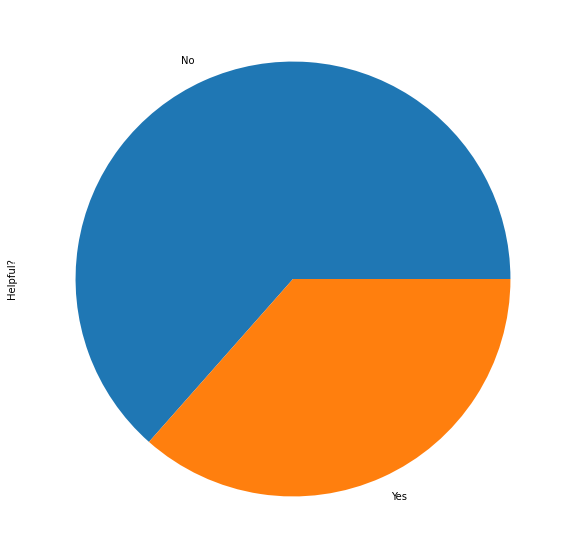

In [ ]:
display(feedbackpd["Helpful?"].value_counts())
feedbackpd["Helpful?"].value_counts().plot.pie(y='mass', figsize=(10, 10))

In [ ]:
display("No Percentage")
display(6961/(6961+4005)*100)
display("Yes Percentage")
display(4005/(6961+4005)*100)

'No Percentage'

63.47802298012037

'Yes Percentage'

36.52197701987963

Almost two thirds of the feedback recieved from the feedback prompt is negative. This is could be due to users being more inclined to provide criticism than praise as praise requires no issues to be fixed.

The following code finds the sections that had the most negative feedback:

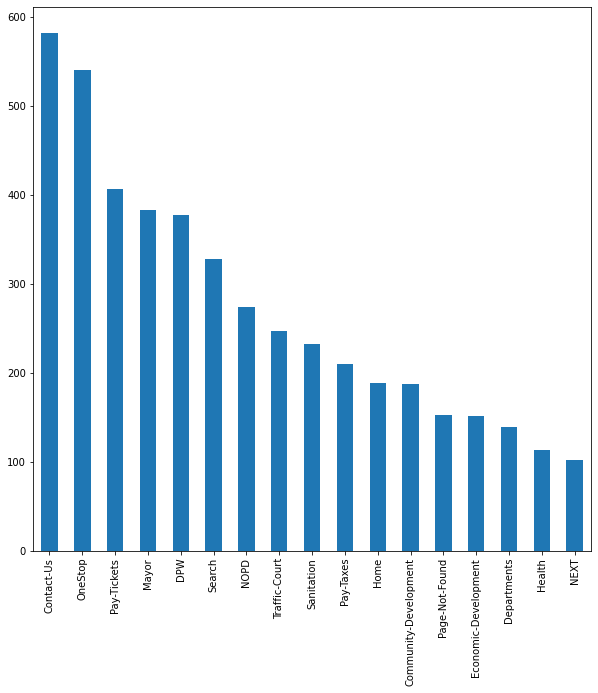

In [ ]:
Nodb = feedbackpd.loc[feedbackpd["Helpful?"] == "No"]
Nodb["Section"].value_counts()
Nodb["Section"].value_counts().loc[Nodb["Section"].value_counts() >= 100].plot.bar(y='mass', figsize=(10, 10))

*Contact Us* Is likely mostly negative as communication with the city is slow. It is also used as an extra way to ask the people at the city to respond and get in contact with individuals. Here is an example of that:

In [ ]:
CU = feedbackpd[feedbackpd["Section"] == "Contact-Us"].iloc[1:2]
CU["Feedback"][152]

"I've been came to y'all for help since 2019 y'all did help me with rental assistance and see if y'all repeat the utility bills they never got paid cuz someone please give me a call I'm trying to reach out for help thank you and have a blessed day.   Rochelle Davis"

*OneStop* Is likely referring to https://onestopapp.nola.gov/, a government site used for applying for permits and licenses. It is in beta, which likely contributes to its glitchy nature as implied by comments. Here is an example a criticism of it:

In [ ]:
OS = feedbackpd[feedbackpd["Section"] == "OneStop"].iloc[2:3]
OS["Feedback"][207]

'Does not give 1/2 the info needed to submit for a permit. This city is so fucking stupid across the board. Not a god damn thing works well here. No one changes shit. No one gives a shit. Fuck it all'

*Pay-Tickets* is negative because people will respond to the prompt if they have trouble paying tickets.

In [ ]:
PT = feedbackpd[feedbackpd["Section"] == "Pay-Tickets"].iloc[0:1]
PT["Feedback"][147]

'You need to send confirmation that online contestations for tickets were received. I submitted my contestation, but did not receive any confirmation afterwards. The last time this happened, I was told my online submission was never received and had to work with your office to reverse additional charges.\n\nPlease let me know if you received my contestation for Parking Violation 620819286'

So most the major feedback hubs are used by users to voice complaints with the government rather than the site. *Search* and other site centric sections may help us more with site issues.

In [ ]:
s = Nodb[feedbackpd["Section"] == "Search"].iloc[:10]
s["Feedback"]

105        Trying to search Orleans One Stop, not Google
135                                              Not yet
253    I WANT MY TRADH PICKED UP!\nI PAY MONTHLY ON T...
466                               I don't have an answer
722    Could not find my application for renewal of m...
784    need instruction on how to find rules pertaini...
818    Seeking Information On capital projects for th...
819                 Did not respond with the information
829    I am trying to find out when a ABO PERMIT IS N...
922    It does not have good information available on...
Name: Feedback, dtype: object

Looking at the first ten, it seems to be a mixed bag of complaints. A lot are still complaints directed at city processes. Some, like 922, are ambiguous. However, some cite specific sources of information users want to access. However it is hard to tie these together with a centralized theme.

**Conclusion:** Many users fill out the prompt to voice complaints they have with the city government rather than genuine feedback for the site. Still, individual feedback specifically identified being related to the site and certain sections less related to government may provide useful.

**Was This Page Helpful.xlsx NLP**

Re-worked code from PublicRecords_NLP.ipynb to run NLP on site feedback data. Bertopic has an element of simulated randomness which can mess around with the order of topics as presented. Please refrain from re-running poriton of code.

Includes all prompts, yes and no, from the dataset to find what people that respond to the prompt are inquiring about. 

In [ ]:
# Install necessary libraries
%%capture
!pip install bertopic
import pandas as pd
import spacy
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Feedback on Website
#May need to point directory at proper file path depending on load context
feedback = pd.read_excel('Was This Page Helpful.xlsx',skiprows=2)
feedback = feedback['Feedback'].tolist()
feedback = [str(i) for i in feedback]

/
/content


In [ ]:
# training
topic_model_1 = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model_1.fit_transform(feedback)

Batches:   0%|          | 0/343 [00:00<?, ?it/s]

In [ ]:
# save model 1
topic_model_1.save("Site Feedback")	

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
# most frequent topics: -1 indicates outliers, ignore
freq = topic_model_1.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,-1,2940,-1_the_to_in_and
1,0,320,0_tax_taxes_property_sales
2,1,299,1_trash_recycling_pickup_pick
3,2,264,2_application_apply_easy_process
4,3,162,3_email_contact_address_addresses
5,4,159,4_map_maps_zoning_district
6,5,153,5_report_police_accident_file
7,6,145,6_ticket_pay_tickets_number
8,7,131,7_updated_update_last_needs
9,8,128,8_monuments_history_statues_confederate


In [ ]:
topic_model_1.get_topic(0) # get the most frequent topic

[('tax', 0.050199305159967546),
 ('taxes', 0.026783154282595076),
 ('property', 0.018971400950171514),
 ('sales', 0.01877661965370169),
 ('inheritance', 0.018456244377285824),
 ('pay', 0.014763474295859622),
 ('estate', 0.014328734659282584),
 ('rolls', 0.012025673091779534),
 ('bill', 0.011481949881338821),
 ('2020', 0.009079972168247434)]

In [ ]:
topic_model_1.get_topic(1) # get the 2nd most frequent topic

[('trash', 0.040353702914277645),
 ('recycling', 0.03747018069131202),
 ('pickup', 0.019263657385025203),
 ('pick', 0.018285225919266734),
 ('garbage', 0.018239588169170335),
 ('recycle', 0.014477882738934276),
 ('picked', 0.012048832975068079),
 ('waste', 0.011837504000493285),
 ('glass', 0.011759256661818257),
 ('up', 0.011055855668862715)]

In [ ]:
# size of each circle = frequency of topic
interactive_map = topic_model_1.visualize_topics(); interactive_map

In [ ]:
# Set labels for top 10 topics
topic_model_1.set_topic_labels({0: "Taxes", 1: "Trash and Recycling",
                                2: "Easy Application Process", 3: "Emails", 4: "Location Data",
                                5: "Police Report", 6: "Ticket Payments", 7: "Needs Update",
                                8: "Monument Removal", 9: "Easy Page Navigation"})

# Display model 1 bar chart
topic_model_1.visualize_barchart(top_n_topics=10, title='Model 1: Topic Word Scores',
                                 custom_labels=True)

The most frequent topics addressed in the prompts on the site according to model one are as follows:
1. Taxes
2. Trash
3. Easy Application Process
4. Emails
5. Location Data
6. Police Report
7. Ticket Payments
8. Needed Updates
9. Monument Removal
10. Easy Page Navigation

In [ ]:
# change ngram_range, let each entity in a topic be up to 3 words
vectorizer_model = CountVectorizer(ngram_range=(1, 3))

# update model 1
topic_model_1.update_topics(feedback, vectorizer_model=vectorizer_model)

In [ ]:
# get most frequent topics: ngram_range = (1,3)
freq = topic_model_1.get_topic_info(); freq.head(20)

,Topic,Count,Name,CustomName
0,-1,2940,-1_the_to_and_in,-1_the_to_in_and
1,0,320,0_tax_taxes_property_sales,Taxes
2,1,299,1_trash_recycling_pickup_pick,Trash and Recycling
3,2,264,2_application_the application_apply_to apply,Easy Application Process
4,3,162,3_email_contact_email address_address,Emails
5,4,159,4_map_the map_maps_district,Location Data
6,5,153,5_report_police report_police_accident,Police Report
7,6,145,6_ticket_pay_my ticket_to pay,Ticket Payments
8,7,131,7_updated_update_be updated_not updated,Needs Update
9,8,128,8_history_monuments_statues_confederate,Monument Removal


In [ ]:
# train a new model with modified topic sizes (min topic size = 5)
topic_model_2 = BERTopic(language="english", min_topic_size=5, calculate_probabilities=True, verbose=True)
topics, probs = topic_model_2.fit_transform(feedback)

Batches:   0%|          | 0/343 [00:00<?, ?it/s]

In [ ]:
# save model 2
topic_model_2.save("Site Feedback 2")	

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [ ]:
# most frequent topics: model 2
freq = topic_model_2.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,-1,3150,-1_in_to_the_and
1,0,173,0_email_contact_address_addresses
2,1,155,1_ticket_tickets_pay_system
3,2,128,2_recycling_recycle_hazardous_glass
4,3,118,3_monuments_statues_history_confederate
5,4,114,4_permit_permits_status_utilityservice
6,5,110,5_nola_nolagov_testing_red
7,6,106,6_staff_department_departments_director
8,7,99,7_trash_pick_pickup_garbage
9,8,86,8_occupational_license_renew_renewal


In [ ]:
topic_model_2.get_topic(0) # get the most frequent topic

[('email', 0.054527725079008896),
 ('contact', 0.039020025785484753),
 ('address', 0.028607607741412248),
 ('addresses', 0.022244878881574795),
 ('send', 0.015626897566013116),
 ('emails', 0.01234298494628762),
 ('no', 0.0095825409662155),
 ('gmailcom', 0.008937100712796851),
 ('an', 0.008597183646683378),
 ('contacts', 0.008508359200230776)]

In [ ]:
topic_model_2.get_topic(1) # get the 2nd most frequent topic

[('ticket', 0.03147025857097084),
 ('tickets', 0.015533266276818862),
 ('pay', 0.015488413544375008),
 ('system', 0.013660472576863222),
 ('number', 0.010375101693643932),
 ('online', 0.008915245453364461),
 ('seatbelt', 0.00784513403900821),
 ('lost', 0.007205221571427408),
 ('my', 0.006523218579567387),
 ('traffic', 0.006021621630494656)]

In [ ]:
# Set labels for top 10 topics
topic_model_2.set_topic_labels({0: "Emails", 1: "Ticket Payments",
                                2: "Recycling", 3: "Monument Removal", 4: "Permits",
                                5: "Site Problems", 6: "Government Staff Info", 7: "Trash",
                                8: "License Renewal", 9: "Meeting Scheduling"})

# Display model 2 bar chart
topic_model_2.visualize_barchart(top_n_topics=10, title='Model 2: Topic Word Scores',
                                 custom_labels=True)

The most frequent topics addressed in the prompts on the site according to model two are as follows:
1. Emails
2. Ticket Payments
3. Recycling
4. Monument Removal
5. Permits
6. Site Problems
7. Government Staff Info
8. Trash
9. License Renewal
10. Meeting Scheduling

In [ ]:
# train a new model with modified topic sizes (topic size = 5)
topic_model_3 = BERTopic(language="english", top_n_words=5, min_topic_size=5,
                         calculate_probabilities=True, verbose=True)
topics, probs = topic_model_3.fit_transform(feedback)

Batches:   0%|          | 0/343 [00:00<?, ?it/s]

In [ ]:
# save model 3
topic_model_3.save("Site Feedback 3")	

In [ ]:
# most frequent topics: model 3
freq = topic_model_3.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,-1,3124,-1_in_the_to_and
1,0,145,0_ticket_pay_tickets_system
2,1,122,1_monuments_statues_history_confederate
3,2,120,2_staff_department_departments_director
4,3,105,3_permit_permits_status_utilityservice
5,4,104,4_nola_nolagov_testing_red
6,5,92,5_occupational_license_renew_renewal
7,6,85,6_helpful_very_helpfull_helpfully
8,7,85,7_parking_handicapped_signs_park
9,8,82,8_job_jobs_looking_position


In [ ]:
topic_model_3.get_topic(0) # get the most frequent topic

[('ticket', 0.032977240241493434),
 ('pay', 0.01586835317611595),
 ('tickets', 0.015111696787445207),
 ('system', 0.012852234187100514),
 ('seatbelt', 0.011685437239165986)]

In [ ]:
topic_model_3.get_topic(1) # get the 2nd most frequent topic

[('monuments', 0.019571791629958795),
 ('statues', 0.017965412810346994),
 ('history', 0.016305375449431267),
 ('confederate', 0.015479648191900125),
 ('removal', 0.010304591552296882)]

In [ ]:
# Set labels for top 10 topics
topic_model_3.set_topic_labels({0: "Ticket Payment", 1: "Monument Removal",
                                2: "Government Staff Info", 3: "Permits", 4: "Site Problems",
                                5: "License Renewal", 6: "Positive reviews", 7: "Parking",
                                8: "Jobs", 9: "Parking Tickets"})

# Display model 3 bar chart
topic_model_3.visualize_barchart(top_n_topics=10, title='Model 3: Topic Word Scores',
                                 custom_labels=True)

The most frequent topics addressed in the prompts on the site according to model three are as follows:
1. Ticket Payment
2. Monument Removal
3. Government Staff Info
4. Permits
5. Site Problems
6. License Renewal
7. Positive Reviews
8. Parking
9. Jobs
10. Parking Tickets

In [ ]:
# train new model, add diversity
topic_model_4 = BERTopic(language="english", calculate_probabilities=True, diversity=0.5, verbose=True)
topics, probs = topic_model_4.fit_transform(feedback)

Batches:   0%|          | 0/343 [00:00<?, ?it/s]

In [ ]:
# save model 4
topic_model_4.save("Site Feedback 4")

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [ ]:
# most frequent topics: model 4
freq = topic_model_4.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,-1,2750,-1_of_to_act_city
1,0,339,0_trash_recycling_schedule_hazardous
2,1,256,1_application_process_assistance_submit
3,2,235,2_ticket_pay_number_camera
4,3,233,3_permits_building_status_need
5,4,174,4_tax_estate_bill_real
6,5,170,5_occupational_renewal_online_form
7,6,165,6_saints_orleans_retrieved_nfl
8,7,158,7_zoning_maps_districts_historic
9,8,158,8_contact_addresses_mail_contacts


In [ ]:
topic_model_4.get_topic(0) # get the most frequent topic

[('trash', 0.03532591746485051),
 ('recycling', 0.033491435840022475),
 ('schedule', 0.009247736879856154),
 ('hazardous', 0.008842625121982153),
 ('disposal', 0.0072081101662160914),
 ('bin', 0.006875363827770731),
 ('drop', 0.006645283329274012),
 ('debris', 0.006318881854952033),
 ('cans', 0.006259780483947966),
 ('plastic', 0.006133736383234737)]

In [ ]:
topic_model_4.get_topic(1) # get the 2nd most frequent topic

[('application', 0.06729468986999905),
 ('process', 0.013548284340057042),
 ('assistance', 0.013545391406992931),
 ('submit', 0.013408886204651468),
 ('app', 0.012273226834474309),
 ('fill', 0.011807524329983408),
 ('very', 0.008199609742785524),
 ('approved', 0.00788290775257908),
 ('status', 0.006928980341811505),
 ('applying', 0.0061565374039563026)]

In [ ]:
# Set labels for top 10 topics
topic_model_4.set_topic_labels({0: "Waste Disposal", 1: "Application Process",
                                2: "Ticket Payment", 3: "Building Permit", 4: "Tax and Bill Payments",
                                5: "License Renewal", 6: "Saints (NFL)", 7: "Location Info",
                                8: "Identifying Info", 9: "Incident Reports"})

# Display model 4 bar chart
topic_model_4.visualize_barchart(top_n_topics=10, title='Model 4: Topic Word Scores',
                                 custom_labels=True)

The most frequent topics addressed in the prompts on the site according to model four are as follows:
1. Waste Disposal
2. Application Process
3. Ticket Payment
4. Building Permit
5. Tax and Bill Payments
6. License Renewal
7. Saints (NFL)
8. Location Info
9. Indentifying Info
10. Incident Reports

**Section Conclusion**

The most significant and re-occuringing word clusters from the dataset were related to: Ticket Payments, Waste Disposal (Trash and Recycling), Obtaining/Renewing permits, Government Officials, and Monument Removal (the recent process of removing confederate monuments).

While we can get an idea of what people are interested in, it is largely intermixed with what general problems people have with the government that are not in our scope to fix (although would make a good service learning  volunteering opportunity). The information in the dataset is generalized to the point where site suggestions only make up a small unorganized fraction of prompt requests and are relatively isolated from one another as they tend to be on a per case basis.

Meaningful further analysis would most likely require sifiting through all 10,966 entries manually to cherry-pick meaningful and relevant suggestions that could hopefully be used to identify greater issues that can be remediated by our group.


## Analyzing Calls For Service Data

Based on our abaove analysis, data related to the NOPD was a frequently mentioned topic of interest. There is also a substantial amount of data on this topic featured on the datadriven.nola.gov site. We have begun to analyze some of these datasets, as they are a potential topic for our final dashboard.

Below, we imported the Calls For Service 2023 dataset. This dataset includes the type of service needed from NOPD, the location of the call, as well as some other topics. From this dataset we decided to mainly focus on the type of service and the location to see what crimes or services occur the most and if there are any correlations between the location of the crime or service needed. We hope to include this analysis in our dashboard.

In [61]:
service = pd.read_csv('Calls_for_Service_2023.csv')
display(service)

,NOPD_Item,Type,TypeText,Priority,InitialType,InitialTypeText,InitialPriority,MapX,MapY,TimeCreate,...,PoliceDistrict,Location,Blocks,Council Districts,Self-Reported Neighborhood Organizations (SRNOs) Boundaries,(ALTERNATE) - Neighborhood Statistical Areas,Zip Codes,Neighborhood Organizations,Police Districts,Census - 2010
0,A0599223,SEXOFF,SEX OFFENSE: GENERAL/MISC,2,ASLT,SIMPLE ASSAULT,1,3662781,517589,01/06/2023 04:55:53 PM,...,2,POINT (-90.12764112 29.91774739),3690.0,1.0,42.0,72.0,3767.0,42.0,3.0,3690.0
1,A0653023,THEFT,THEFT,2,BURGV,BURGLARY FROM VEHICLE,0,3706231,564651,01/07/2023 07:05:08 AM,...,7,POINT (-89.98874997 30.04582091),1211.0,5.0,158.0,20.0,4149.0,158.0,1.0,1211.0
2,A0700123,MENTAL,EMOTIONALLY DISTURBED PERSON,1,MENTAL,EMOTIONALLY DISTURBED PERSON,2,37369000,3513814,01/07/2023 05:15:17 PM,...,0,POINT (0 0),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A0650123,PRIS,PRISONER TRANSPORT,1,PRIS,PRISONER TRANSPORT,1,3692978,529549,01/07/2023 06:08:31 AM,...,4,POINT (-90.03189701 29.94972492),9160.0,3.0,2.0,1.0,3456.0,2.0,2.0,9160.0
4,A0650423,PRIS,PRISONER TRANSPORT,1,PRIS,PRISONER TRANSPORT,1,3692978,529549,01/07/2023 06:09:51 AM,...,4,POINT (-90.03189701 29.94972492),9160.0,3.0,2.0,1.0,3456.0,2.0,2.0,9160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20429,A2189023,MISC,MISCELLANEOUS COMPLAINT,1,MISC,MISCELLANEOUS COMPLAINT,1,3700556,518293,01/22/2023 01:16:29 PM,...,4,POINT (-90.00837902 29.91853377),3588.0,3.0,2.0,5.0,4153.0,2.0,2.0,3588.0
20430,A2179123,BURGV,BURGLARY FROM VEHICLE,0,BURGV,BURGLARY FROM VEHICLE,0,3682428,529866,01/22/2023 10:48:31 AM,...,8,POINT (-90.0651976 29.95092008),8996.0,3.0,23.0,69.0,4152.0,23.0,5.0,8996.0
20431,A2219023,MISC,MISCELLANEOUS COMPLAINT,1,MISC,MISCELLANEOUS COMPLAINT,1,3670740,553837,01/22/2023 09:23:37 PM,...,3,POINT (-90.10128725 30.01718249),13860.0,1.0,106.0,38.0,3772.0,106.0,7.0,13860.0
20432,A2164223,VEHSTO,VEHICLE STOLEN,0,VEHSTO,VEHICLE STOLEN,0,3680616,543552,01/22/2023 07:03:53 AM,...,3,POINT (-90.07043977 29.98860718),8455.0,4.0,134.0,21.0,3768.0,134.0,7.0,8455.0


In [62]:
display(service['TypeText'])

0           SEX OFFENSE: GENERAL/MISC
1                               THEFT
2        EMOTIONALLY DISTURBED PERSON
3                  PRISONER TRANSPORT
4                  PRISONER TRANSPORT
                     ...             
20429         MISCELLANEOUS COMPLAINT
20430           BURGLARY FROM VEHICLE
20431         MISCELLANEOUS COMPLAINT
20432                  VEHICLE STOLEN
20433         MISCELLANEOUS COMPLAINT
Name: TypeText, Length: 20434, dtype: object

In [63]:
type = service['TypeText']
type.value_counts()

MISCELLANEOUS COMPLAINT             5131
DISORDERLY CONDUCT                  1035
AREA CHECK                           919
INVESTIGATION: POLICE DEPARTMENT     849
VEHICLE STOLEN                       683
                                    ... 
SEX OFFENDER REGISTRATION CHECK        1
SEXUAL BATTERY                         1
TRUANT VIOLATION                       1
ATTACHMENT                             1
TRAFFIC INCIDENT                       1
Name: TypeText, Length: 170, dtype: int64

MISCELLANEOUS COMPLAINT             5131
DISORDERLY CONDUCT                  1035
AREA CHECK                           919
INVESTIGATION: POLICE DEPARTMENT     849
VEHICLE STOLEN                       683
                                    ... 
SEX OFFENDER REGISTRATION CHECK        1
SEXUAL BATTERY                         1
TRUANT VIOLATION                       1
ATTACHMENT                             1
TRAFFIC INCIDENT                       1
Name: TypeText, Length: 170, dtype: int64

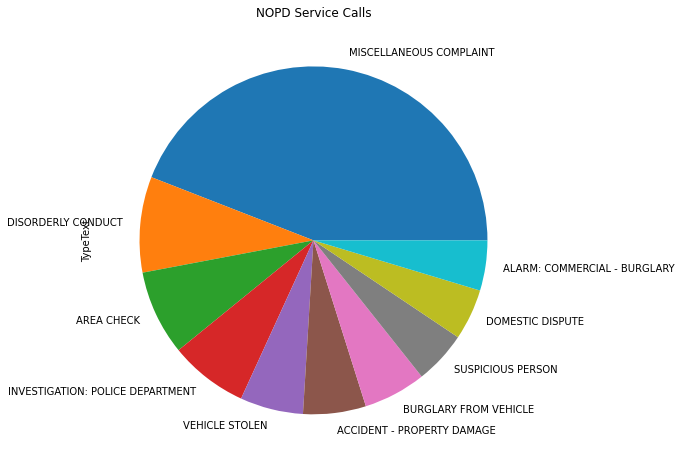

In [64]:
display(service["TypeText"].value_counts())
service["TypeText"].value_counts().head(10).plot.pie(y='mass', figsize=(8, 8),title = 'NOPD Service Calls')

In [65]:
NOLA = gpd.read_file('nola.shx')

In [66]:
NOLA

,geometry
0,"POLYGON ((-90.07616 29.98025, -90.07632 29.980..."
1,"POLYGON ((-90.01666 30.03358, -90.01665 30.033..."
2,"POLYGON ((-90.12216 29.91968, -90.12224 29.919..."
3,"POLYGON ((-90.02074 30.02099, -90.02070 30.020..."
4,"POLYGON ((-89.99281 30.04027, -89.99275 30.040..."
...,...
154767,"POLYGON ((-90.06904 30.01728, -90.06903 30.017..."
154768,"POLYGON ((-89.99791 30.02397, -89.99805 30.023..."
154769,"POLYGON ((-90.07671 30.02169, -90.07668 30.021..."
154770,"POLYGON ((-90.01196 29.91488, -90.01192 29.914..."


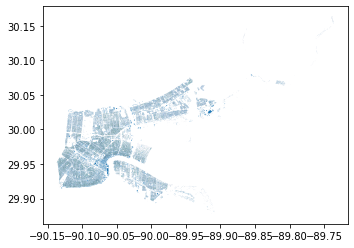

In [67]:
NOLA.plot()

In [68]:
service = pd.read_csv('Calls_for_Service_2023.csv')
service['geometry'] = service['Location']

In [69]:
service['geometry'] = gpd.GeoSeries.from_wkt(service['geometry'])
my_geo_df = gpd.GeoDataFrame(service, geometry='geometry')

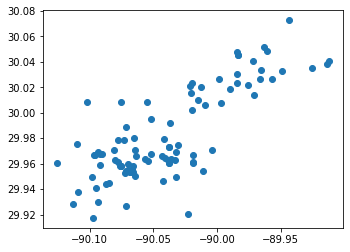

In [70]:
test = my_geo_df[4:100]
test.plot()

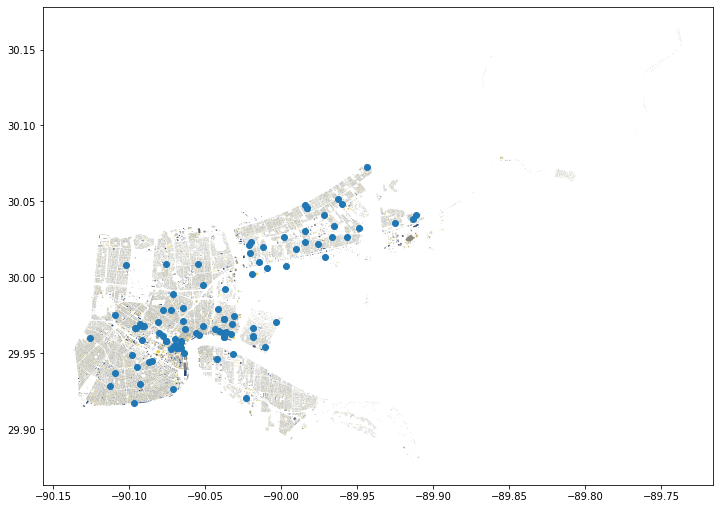

In [71]:
fig, ax = plt.subplots(figsize=(12,12))

NOLA.plot(ax=ax,alpha=1,linewidth=1,cmap="cividis")
test.plot(ax=ax)